During my internship at Kibo Commerce, my mentor <a href="https://austinrochford.com/"> Austin Rochford. </a>
introduced me to the powerful probabilistic programming package PyMC3 (he is one of the contributors). 

As a scientist, I am immediately hooked by the ideas of this library. There are so many things that I love about it; just to name a few: numerical computations, automatic differentiation, simulations with Markov Chain Monte Carlo method, and above all, a huge potential to solve real-world problems. 

I decided to master this library by doing some hands-on projects. This is one of them. More precisely, in this project, I will use PyMC3 to do Bayesian logistic regression using the following public dataset: 
<a href="https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+"> Occupancy Detection Data Set. </a>

The dataset contains several variables such as light, temperature, humidity, and CO2 levels. The goal is to detect a room's occupancy from these variables.



First, we will need to load several relevant packages. 

In [155]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano.tensor as tt
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix


Next, we load the dataset.

In [4]:
df=pd.read_csv('datatest.txt')
df.sample(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1241,2015-02-03 08:39:59,20.840000,24.840000,434.5,686.0,0.003779,1
645,2015-02-02 22:44:00,20.700000,22.500000,0.0,462.0,0.003391,0
1334,2015-02-03 10:13:00,21.700000,27.912000,474.0,1073.4,0.004481,1
2183,2015-02-04 00:22:00,20.850000,24.956000,0.0,547.6,0.003799,0
2196,2015-02-04 00:35:00,20.823333,24.926667,0.0,542.0,0.003788,0


For convenience, we convert the date variable into a datetime object. 

In [5]:
df['date']=pd.to_datetime(df['date'])

# Part 1: Exploratory Data Analysis

First, let us take an overview of the dataset. 

In [6]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


We see that there are 2655 samples in this dataset. Furthermore, there are no missing values. Let us also take a look at the timeframe of this dataset. 

In [7]:
df['date'].describe()

count                    2665
unique                   2665
top       2015-02-03 07:25:59
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: date, dtype: object

We see that our data are collected in only three days.

We will explore our variables and their relationship. First, let us plot the temperature variable.

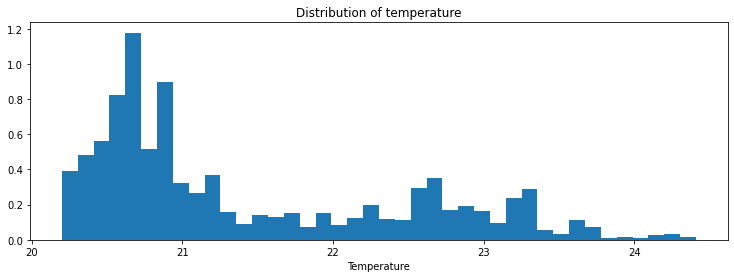

In [8]:
figsize(12.5, 4)
plt.hist(df['Temperature'], bins=40, density=True, label='Temperature')
plt.xlabel('Temperature')
plt.title('Distribution of temperature')
plt.show()

We see that the temperature has a heavy tail distribution. What about the Humidity variable?

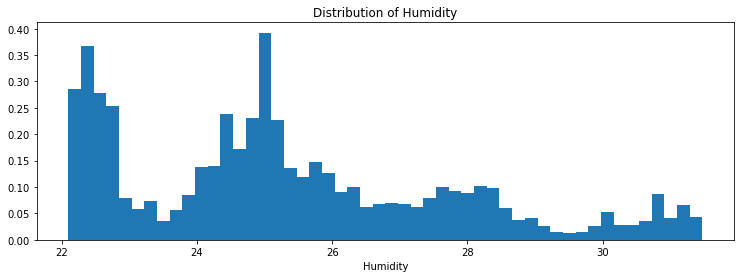

In [9]:
figsize(12.5, 4)
plt.hist(df['Humidity'], bins=50, density=True, label='Humidity')
plt.xlabel('Humidity')
plt.title('Distribution of Humidity')
plt.show()

It is interesting to see that there are two peaks around 22.5 and 25. We are also interested in the Light variable during different days.  

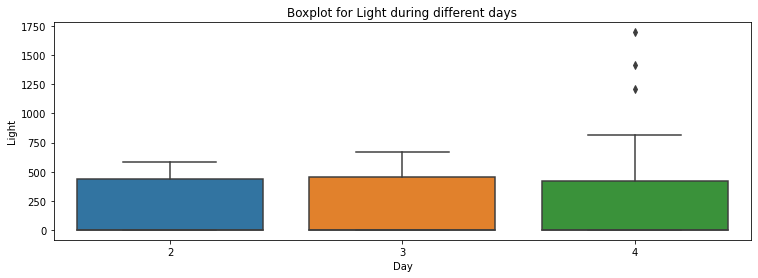

In [115]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['Light'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for Light during different days')
plt.show()

We see that the distributions of light are almost identical during these three days. Next, let us take a look at the CO2 level. 

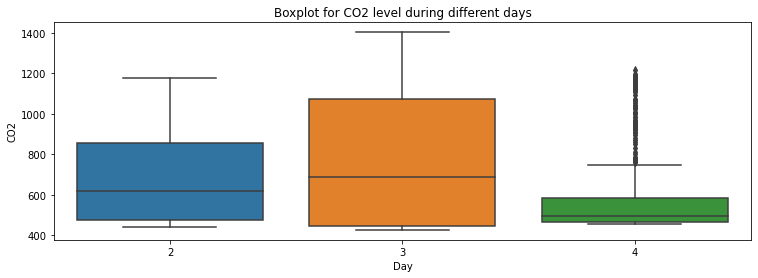

In [114]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['CO2'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for CO2 level during different days')
plt.show()

These distributions are significantly different. There are lots of outliers on 2/4/2015. Finally, we will dive into the Humidity Ratio variable.

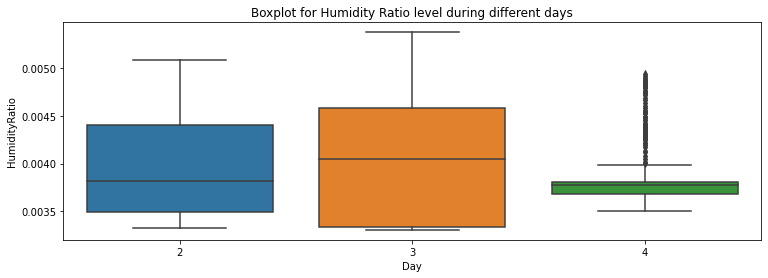

In [113]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['HumidityRatio'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for Humidity Ratio level during different days')
plt.show()

This looks pretty much similar to the boxplot for CO2 level. Maybe, there is a strong correlation between the CO2 level and Humidy Ratio. We can check that by using a scatter plot for these two variables.

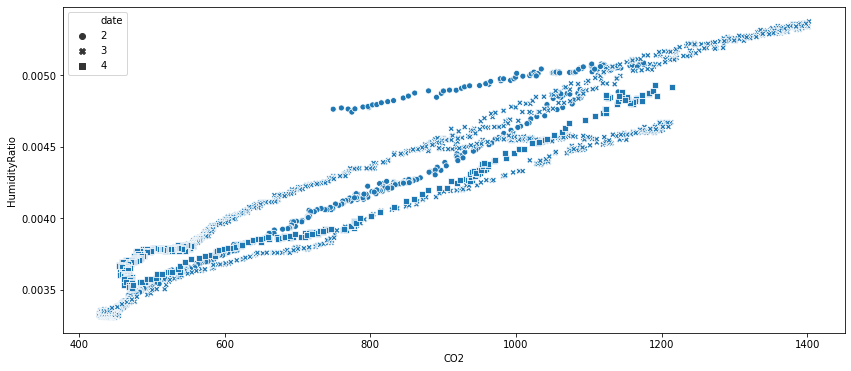

In [13]:
ax=sns.scatterplot(df['CO2'], df['HumidityRatio'], style=df['date'].dt.day)

Indeed, there is a strong linear relationship between the CO2 level and Humidity Ratio. Let us take an overview of the relation between our variables. This can be done by the pairplot function with seaborn.

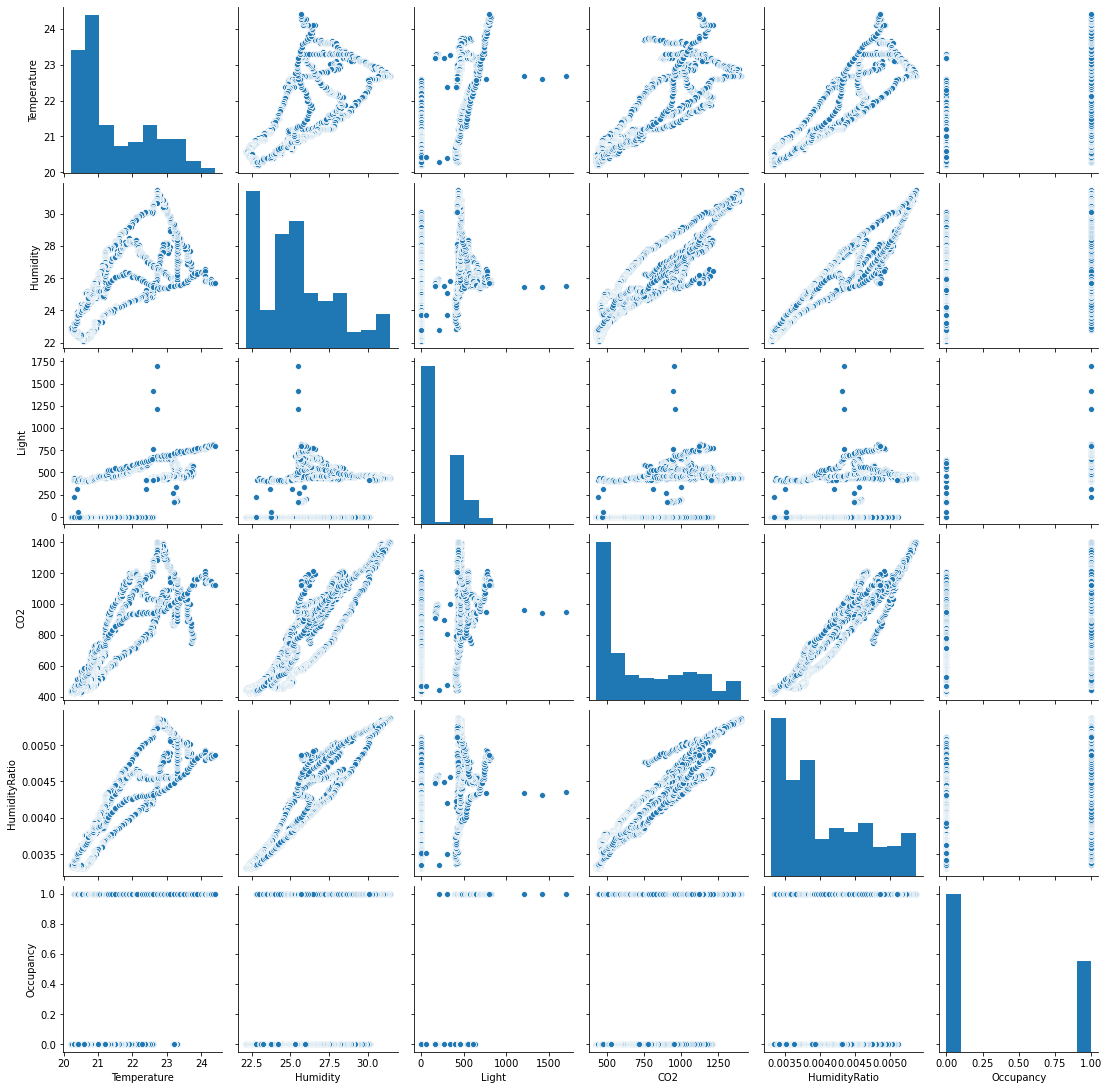

In [14]:
ax=seaborn.pairplot(df)


This visually shows that there is a strong linear relationship between the following pairs: CO2 and temperature, CO2 and Humidity, Humidity and Humidity Ratio, Humidity Ration and CO2. We can even quantify these relations by plotting the heatmap. 



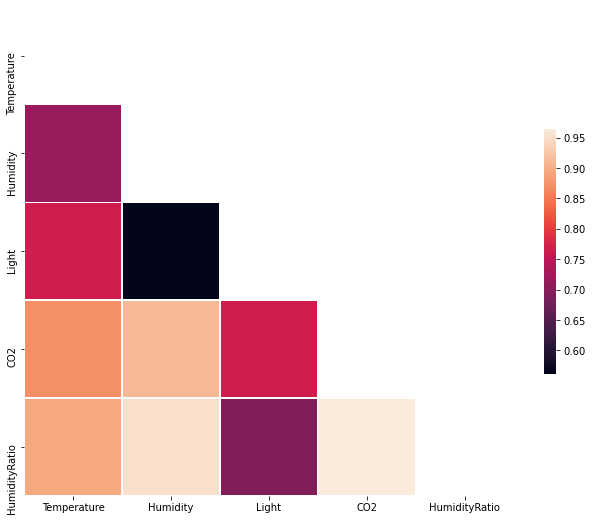

In [15]:
corr=df.iloc[:, 1:-1].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We see that the two pairs Humidity-Humidity Ration and Humidity Ratio-CO2 express the strongest linear relationship. 

# Part 2: Bayesian logistic models with PyMC3

We will build several machine learning models to classifiy Occupancy based on other variables. 


Recall that we have a binary decision problem. In other words, our target variable is assumed to follow a Bernoulli random variable with $p$ given by:

$$p=logit \left( \beta_0+ \sum_{\text{var}} \beta_{\text{var}} \text{var} \right)$$
where var is the set of all variables that we use in our model and logit is the logistic function. 

To build a Bayesian logistic regression model, we first have to put a prior distribution on each parameter. The choice of these priors will affect the outcome (though with more data, they probably will "converge"  to the same distribution.) 


Once our priors are specified, PyMC3 will numerically approximate the posterior distributions using Markov Chain Monte Carlo simutations and its generalizations. We can then use samples from these posteriors to make inferences. 



# Part 2.1: First model with priors having uniform distributions.

Since we have no prior knowledge about these parameters, we can assume that they could be anything. In other words, we assume that all $\beta_{\text{var}}$ follows a uniform distribution with large lower and upper bounds.

In [55]:
lower=-10**6
higher=10**6
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_temp=pm.Uniform('beta_temp', lower, higher)
    beta_humid=pm.Uniform('beta_humid', lower, higher)
    beta_light=pm.Uniform('beta_light', lower, higher)
    beta_co2=pm.Uniform('beta_co2', lower, higher)
    beta_humid_ratio=pm.Uniform('beta_humid_ration', lower, higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
                               beta_humid*df['Humidity']+
                               beta_light*df['Light']+
                               beta_co2*df['CO2']+
                               beta_humid_ratio*df['HumidityRatio']))
with first_model:
    #fit the data 
    observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    burned_trace=trace[15000:]    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_humid_ration]
>Metropolis: [beta_co2]
>Metropolis: [beta_light]
>Metropolis: [beta_humid]
>Metropolis: [beta_temp]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


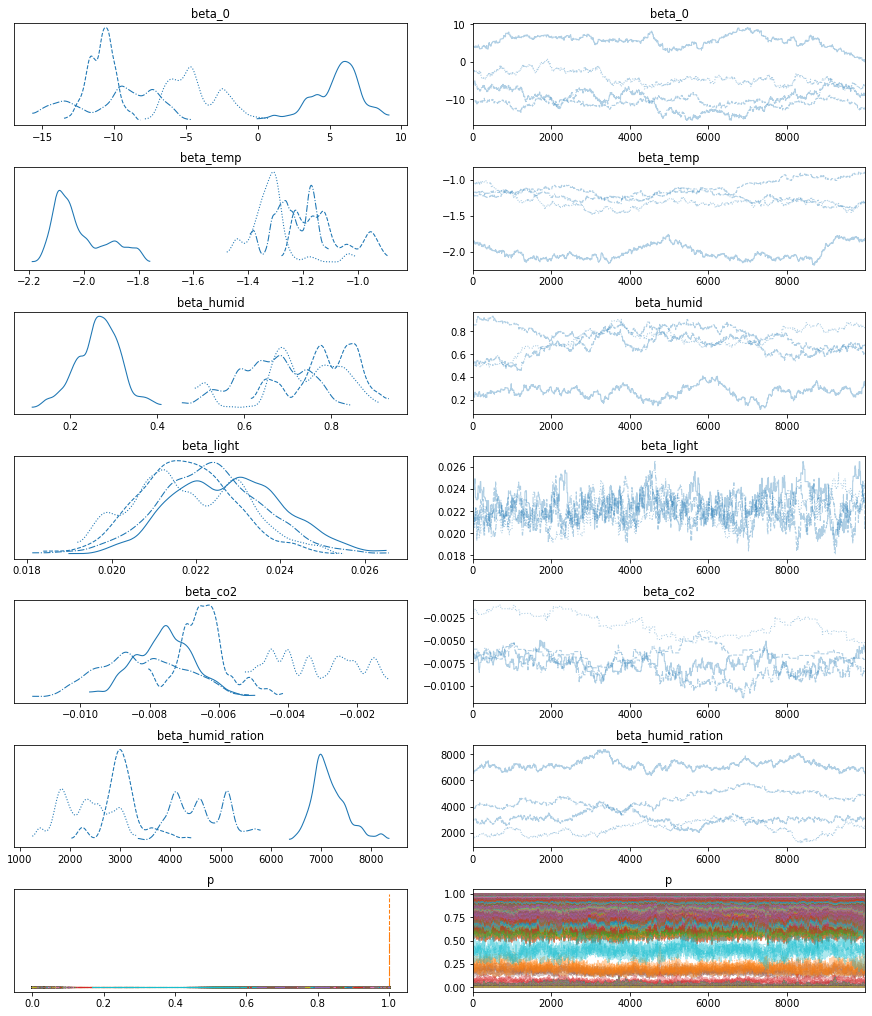

In [56]:
pm.traceplot(burned_trace)
plt.show() 

We can compute the mean of these posterior distributions.

In [77]:
coeffs=['beta_0', 'beta_temp', 'beta_humid', 'beta_light', 'beta_co2', 'beta_humid_ration']
d=dict()
for item in coeffs:
    d[item]=[burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs
#coeff_result=pd.DataFrame(d)    
#coeff_result

,beta_0,beta_temp,beta_humid,beta_light,beta_co2,beta_humid_ration
0,-4.894044,-1.419402,0.610073,0.022182,-0.006352,4292.568088


An advantage of Bayesian statistics in comparison with frequentist statistics is that we have a lot more than just a mean value. In particular, we can even compute the 95% High Density Interval for those parameters. 

In [100]:
pm.stats.hpd(burned_trace['beta_0'])
coeffs=['beta_0', 'beta_temp', 'beta_humid', 'beta_light', 'beta_co2', 'beta_humid_ration']
interval=dict()

for item in coeffs:
    interval[item]=pm.stats.hpd(burned_trace[item]) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
result_coeffs
#coeff_result=pd.DataFrame(d)    
#coeff_result

/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


,beta_0,beta_temp,beta_humid,beta_light,beta_co2,beta_humid_ration
lower,-13.772959,-2.141212,0.200856,0.019764,-0.009954,1673.436024
upper,7.179214,-1.011761,0.871514,0.024553,-0.001992,7512.371763


Note that, the coefficients of Humid Ratio is significantly bigger than other coefficients. That does not neccessarily mean that this variable is more important. If we take a close look at the data, we see that this variable takes very small values. 

Furthermore, we can explore the relationship between different parameters. For example, let us take a look at the beta_co2 and beta_humid_ratio coefficients. 

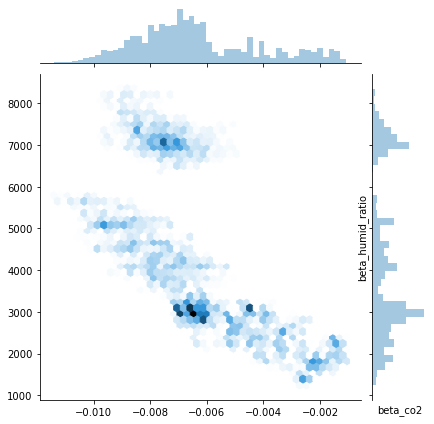

In [112]:
figsize(12.5, 12.5)
seaborn.jointplot(burned_trace['beta_co2'], burned_trace['beta_humid_ration'], kind="hex") #color="#4CB391")
plt.xlabel("beta_co2")
plt.ylabel("beta_humid_ratio");

The plots show that these two coefficients are negatively correlated. Note that CO2 level and Humidity Ratio are positvely correlated.

Recall that in clasicial logistic regression, we find for the best parameters by maximum a posteriori estimation (MAP solution). In other words, the best-fitted parameters are given by 

$$\theta^{*} =\text{argmax}_{\theta} p(\theta|D)=\text{argmax}_{\theta} p(D|\theta) p(\theta)$$

where $p(\theta|D)$ is the posterior distribution of $\theta$ given the data, $p(D|\theta)$ is the likelyhood function, and $p(\theta)$ is the prior distribution of $\theta$. 

Note that since we use uniform distributions on our first model, we can expect that our MAP solution should coincide with MLE solution which corresponds to frequentist logistic regression). We can use the Scikit-Learn library to test this statement. First, we compute the coefficients using MAP. 

In [130]:
coeffs=['beta_0', 'beta_temp', 'beta_humid', 'beta_light', 'beta_co2', 'beta_humid_ration']
d=dict()
for item in coeffs:
    d[item]=[float(start[item])]
    
map_coeffs=pd.DataFrame.from_dict(d)    
map_coeffs

,beta_0,beta_temp,beta_humid,beta_light,beta_co2,beta_humid_ration
0,-0.024541,-1.104235,0.63994,0.019915,0.001542,-0.000015


Next, we compute the beta coefficients using classical logistic regression (frequentist approach).

In [131]:
from sklearn.linear_model import LogisticRegression

In [137]:
X=df.iloc[:, 1: -1]
y=df['Occupancy']
logit=LogisticRegression()
logit_model=logit.fit(X,y)
pd.DataFrame(logit_model.coef_, columns=X.columns)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,-1.071181,0.611712,0.019776,0.001608,-0.000015


Indeed, the coefficients for the two methods are almost identical. 

Next, we discuss the prediction power of our model and compare it with the classical logistic regression. We we record the prediction using the classical method. 

In [159]:
logit_prediction=logit_model.predict(X)

To make prediction with our Bayesian logistic model, we compute the $y_{\text{score}}$ by averaging over our sample values.

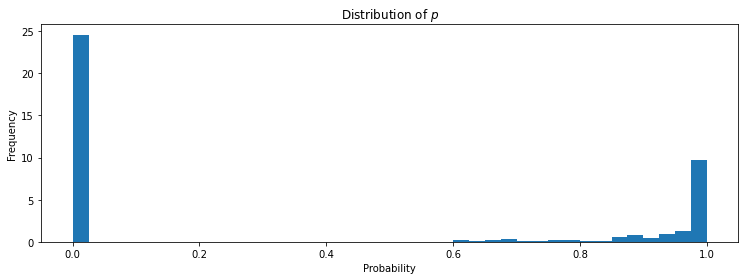

In [286]:
#compute the average probability of predicting 1. 
y_score = np.mean(burned_trace['p'], axis=0)

#histogram of the distribution
figsize(12.5,4)
plt.hist(y_score, bins=40, density=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of $p$')
plt.show()

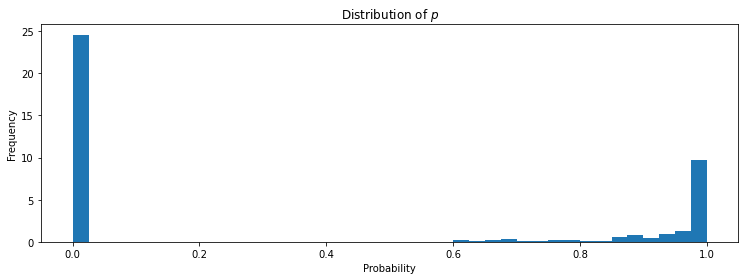

In [148]:
figsize(12.5,4)
plt.hist(y_score, bins=40, density=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of $p$')
plt.show()

It is interesting to see that the majority of $p$ is concentrated neare $0$ and $1$. We can use y_score to make prediction as well. 

In [165]:
first_model_prediction=[1 if x >0.5 else 0 for x in y_score]

Let us evaluate the the performance of our model by computing the confussion matrix.

In [170]:
first_model_confussion_matrix =confusion_matrix(df['Occupancy'], first_model_prediction)
first_model_confussion_matrix

array([[1639,   54],
       [   3,  969]])

This is pretty good. We can even quantify the performance by other metrics as well. 

In [173]:
import sklearn
from sklearn.metrics import classification_report

print(sklearn.metrics.classification_report(y, first_model_prediction))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1693
           1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665



In [174]:
pred_scores = dict(y_true=df['Occupancy'],y_score=y_score)
roc_auc_score(**pred_scores)

0.99358530283253

So, our model performs pretty well. Let's compare it with the classical logistic regression. 

In [177]:
print(sklearn.metrics.classification_report(y, logit_prediction))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1693
           1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665



They are the same! However, with the Bayesian model, we gain more information and hence we are more confident about our estimations.  

# Part 2.2: A different model with priors having normal distributions.

Now, let us train our model using a different set of priors. For example, we can assume that the coefficients follow normal distributions. 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_humid_ration]
>Metropolis: [beta_co2]
>Metropolis: [beta_light]
>Metropolis: [beta_humid]
>Metropolis: [beta_temp]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


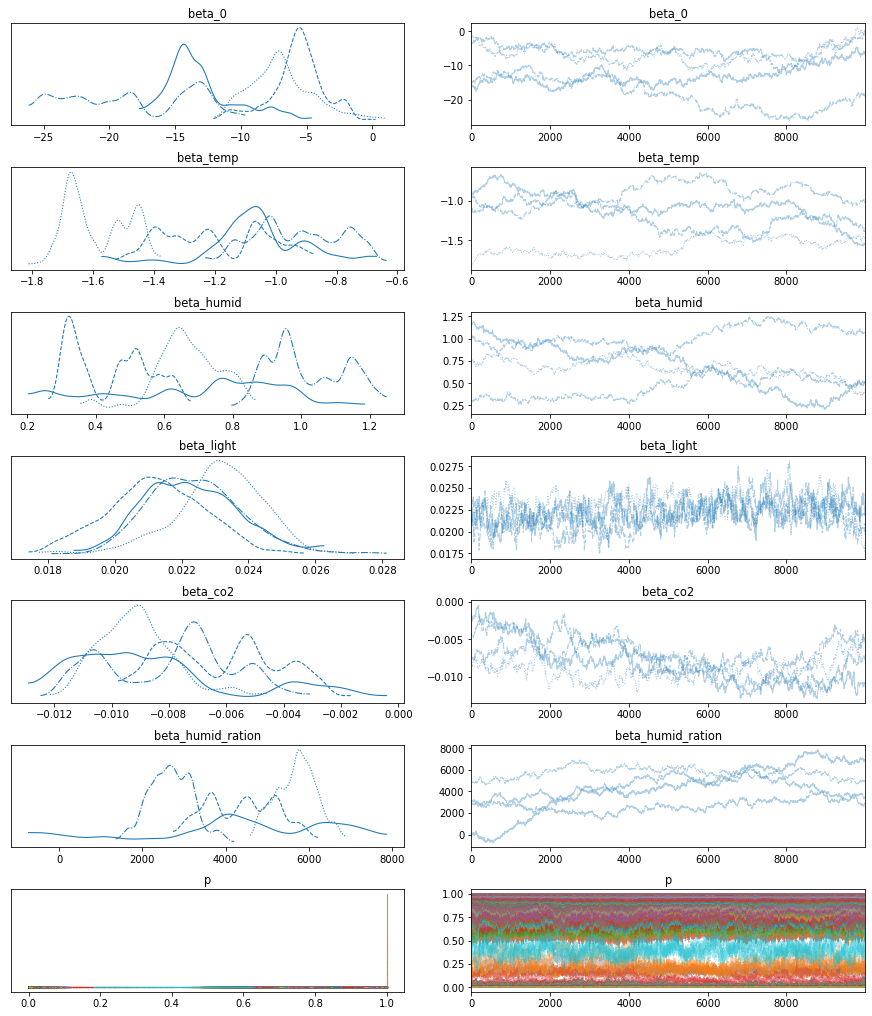

In [178]:
with pm.Model() as second_model:
    beta_0=pm.Normal('beta_0', mu=0, sd=10**4)
    beta_temp=pm.Normal('beta_temp', mu=0, sd=10**4)
    beta_humid=pm.Normal('beta_humid', mu=0, sd=10**4)
    beta_light=pm.Normal('beta_light', mu=0, sd=10**4)
    beta_co2=pm.Normal('beta_co2', mu=0, sd=10**4)
    beta_humid_ratio=pm.Normal('beta_humid_ration', mu=0, sd=10**4)
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
                               beta_humid*df['Humidity']+
                               beta_light*df['Light']+
                               beta_co2*df['CO2']+
                               beta_humid_ratio*df['HumidityRatio']))
with second_model:
    observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
    start=pm.find_MAP()
    step=pm.Metropolis()
    second_trace=pm.sample(25000, step=step, start=start)
    second_burned_trace=second_trace[15000:]
pm.traceplot(second_burned_trace)
plt.show()    

Let us compute the beta coefficients for the MAP solution. 

In [179]:
coeffs=['beta_0', 'beta_temp', 'beta_humid', 'beta_light', 'beta_co2', 'beta_humid_ration']
d=dict()
for item in coeffs:
    d[item]=[float(start[item])]
    
second_map_coeffs=pd.DataFrame.from_dict(d)    
second_map_coeffs

,beta_0,beta_temp,beta_humid,beta_light,beta_co2,beta_humid_ration
0,-0.024518,-1.104166,0.639881,0.019915,0.001542,-0.000015


We see that they are very closed to the ones that we got in the first model. To go further, as we are in a Bayesian framework, we can even compare the posterior distributions across the two models. For example, let take a look the the intercept variable.

No handles with labels found to put in legend.


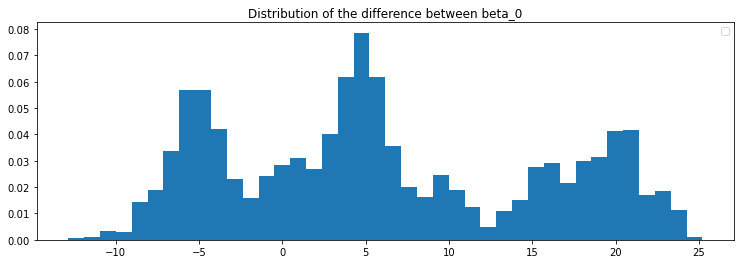

In [206]:
figsize(12.5,4)
plt.hist(burned_trace['beta_0']-second_burned_trace['beta_0'], bins=40, density=True)
plt.title('Distribution of the difference between beta_0')
plt.legend()
plt.show()

While the MAP solutions give the same estimation for $\beta_0$, we see that the two posteriors are rather different. Let us also compare the posterior distributions of $\beta_{\text{temp}}$ between these two models.

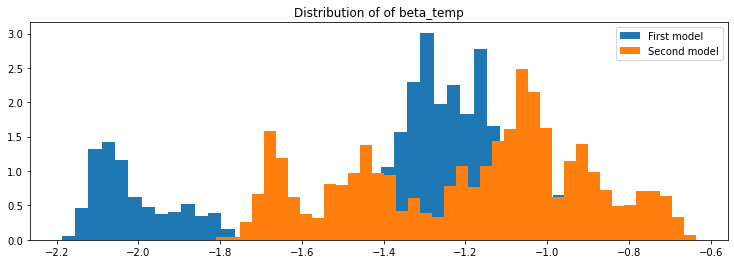

In [273]:
figsize(12.5,4)
plt.hist(burned_trace['beta_temp'], label='First model', bins=40, density=True)
plt.hist(second_burned_trace['beta_temp'], bins=40, label='Second model', density=True)
plt.title('Distribution of of beta_temp')
plt.legend()
plt.show()

We see that the difference is in fact small. 

Next, let us compute the prediction power of the second model.

In [181]:
second_y_score = np.mean(second_burned_trace['p'], axis=0)
second_model_prediction=[1 if x >0.5 else 0 for x in second_y_score]
second_model_confussion_matrix =confusion_matrix(df['Occupancy'], second_model_prediction)
second_model_confussion_matrix

array([[1639,   54],
       [   3,  969]])

This is indentical to the result that we got from the first model. We can check that the y_score and second_y_score are almost the same. 

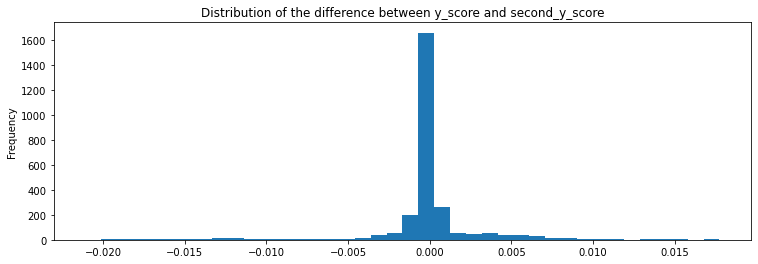

In [187]:
figsize(12.5,4)
plt.hist(y_score-second_y_score, bins=40)
plt.title('Distribution of the difference between y_score and second_y_score')
plt.ylabel('Frequency')
plt.show()

# Part 2.3: A model with built in Generalized Linear Model (GLM).

In the previous sections, we use a hands-on approach to build our models. This is rather easy because we only have a few variables. When the number of variables is very large, it will not be very practical. Fortunately, PyMC3 has a built-in generalized linear model in which everything will be automated. Let us use this built-in model to fit our data.

In [214]:
with pm.Model() as third_model:
    pm.glm.GLM.from_formula('Occupancy ~ Temperature + Humidity + Light + CO2 + HumidityRatio',
                            df,
                            family=pm.glm.families.Binomial())
    third_trace = pm.sample(25000, tune=10000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HumidityRatio, CO2, Light, Humidity, Temperature, Intercept]


Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 3493 seconds.
There were 6987 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1346 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6455 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2775 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


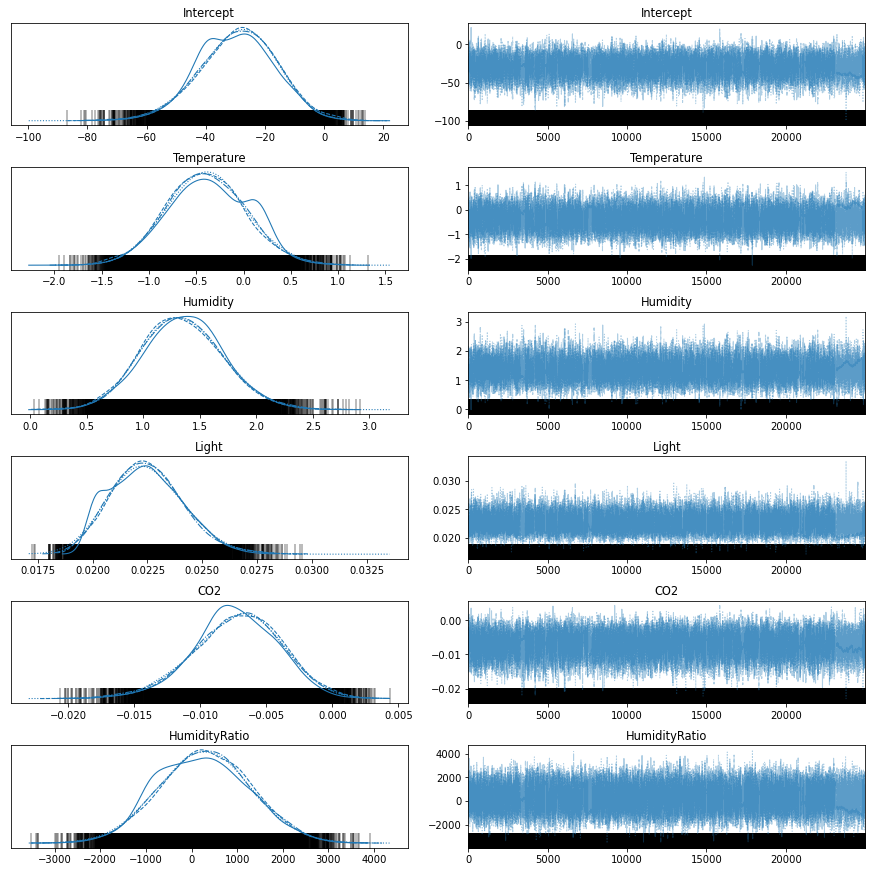

In [219]:
pm.traceplot(third_trace)
plt.show()

Unlike the previous models, the posterior distributions of our parameters are unimodal in this case. 

Let us get a summary of these posterior distributions.

In [230]:
pm.summary(third_trace)

/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-29.275,12.778,-52.791,-5.124,0.186,0.132,4715.0,4715.0,4668.0,7088.0,1.0
Temperature,-0.383,0.417,-1.166,0.381,0.008,0.006,2522.0,2522.0,2582.0,8409.0,1.0
Humidity,1.352,0.354,0.679,2.010,0.005,0.003,5659.0,5659.0,5603.0,6526.0,1.0
Light,0.022,0.002,0.020,0.026,0.000,0.000,1874.0,1874.0,1682.0,1524.0,1.0
CO2,-0.007,0.003,-0.013,-0.001,0.000,0.000,6778.0,6778.0,6602.0,8837.0,1.0
HumidityRatio,285.685,987.038,-1527.588,2146.045,13.074,9.245,5699.0,5699.0,5775.0,16477.0,1.0


Instead of looking at summarized statistics, we can also look at the MAP solution.

In [234]:
with third_model:
    map_solution=pm.find_MAP()
d=dict()
for item in map_solution.keys():
    d[item]=[float(map_solution[item])]
    
third_map_coeffs=pd.DataFrame.from_dict(d)    
third_map_coeffs    

,Intercept,Temperature,Humidity,Light,CO2,HumidityRatio
0,-0.001566,-0.029518,-0.031406,0.99082,0.128127,-0.000004


Recall that the MAP coefficients in the second model is given below

In [235]:
second_map_coeffs

,beta_0,beta_temp,beta_humid,beta_light,beta_co2,beta_humid_ration
0,-0.024518,-1.104166,0.639881,0.019915,0.001542,-0.000015


We see that there are significant difference between the MAP solutions between the second and the third model. What about prediction?

In [249]:
with third_model:
    ppc = pm.sample_posterior_predictive(third_trace, samples=15000)


In [260]:
#compute y_score 
with third_model:
    third_y_score = np.mean(ppc['y'], axis=0)
#convert y_score into binary decisions    
third_model_prediction=[1 if x >0.5 else 0 for x in third_y_score]

#compute confussion matrix 
third_model_confussion_matrix =confusion_matrix(df['Occupancy'], third_model_prediction)
third_model_confussion_matrix

array([[1639,   54],
       [   3,  969]])

We see that the confussion matrix is indentical with the ones from the first two models. What about the distributions of y_scores for the second and the third model?

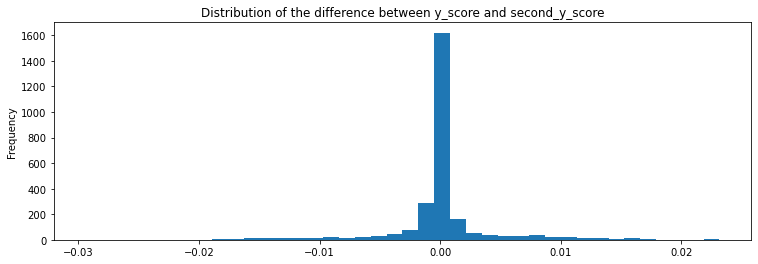

In [266]:
figsize(12.5,4)
plt.hist(third_y_score-second_y_score, bins=40)
plt.title('Distribution of the difference between y_score and second_y_score')
plt.ylabel('Frequency')
plt.show()

We see that the this distribution concentrates around 0. In other words, the distribution of y_scores are almost the same across different models. What about the coefficients, for example the coefficients for temperature? 

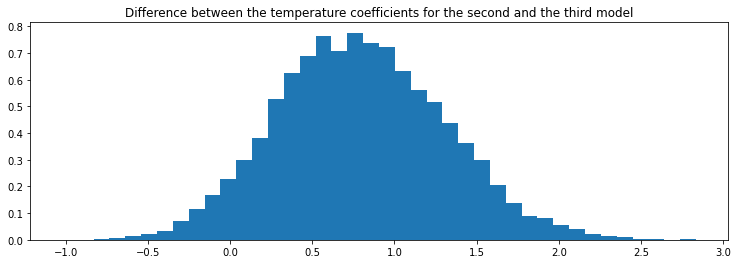

In [280]:
figsize(12.5,4)
plt.hist(third_trace['Temperature'][-40000:]-second_burned_trace['beta_temp'], bins=40, density=True)
plt.title('Difference between the temperature coefficients for the second and the third model')
plt.show()

We see that the different approximately follow a normal distribution with small mean. 

Let us also check the difference between the humidity coefficients. 

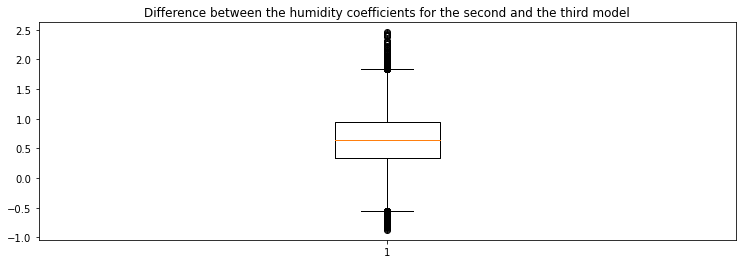

In [284]:
figsize(12.5,4)
plt.boxplot(third_trace['Humidity'][-40000:]-second_burned_trace['beta_humid'])
plt.title('Difference between the humidity coefficients for the second and the third model')
plt.show()

Again, we see that difference is small.

# 3. Conclusion 



We see that even though our models use different priors, the prediction performances are similar. This confirms our belief that as our dataset gets bigger, they should converge to the same solution. 

# 4. References. 

1. https://docs.pymc.io/notebooks/GLM-logistic.html  Official PyMC3 documentation
    
2. https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/
    
    